In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

sns.set_style('whitegrid')

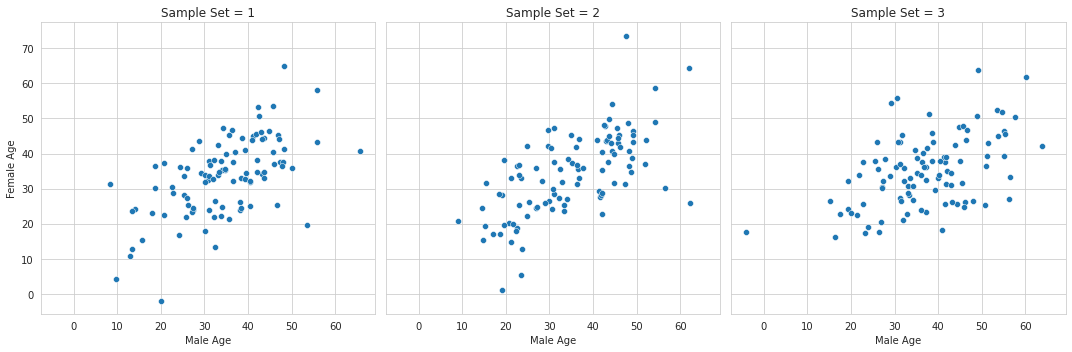

In [109]:
def getMVNPriorSamples(rvTheta, rvS, nEpochs):
    samples = []
    for i in range(nEpochs):
        S = rvS.rvs()
        θ = rvTheta.rvs()
        y = stats.multivariate_normal(θ, S).rvs()
        samples.append(y)
    
    return samples
    
np.random.seed(53423)

SigmaPrior = stats.invwishart(3, np.array([[5, 0], [0, 5]]))
thetaPrior = stats.multivariate_normal(np.array([35,33]), np.array([[1, 0.6], [0.6, 1]])*100)

fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
for i in range(3):
    sns.scatterplot(data=pd.DataFrame(getMVNPriorSamples(thetaPrior, SigmaPrior, 100)), x=0, y=1, ax=ax[i])
    ax[i].set_xlabel("Male Age")
    ax[i].set_ylabel("Female Age")
    ax[i].set_title(f"Sample Set = {i+1}")

fig.tight_layout()
fig.show()

In [99]:
from numpy.linalg import inv

# get data
df = pd.read_csv("agehw.dat", delimiter=" ")

# prior parameters
μ0 = np.array([35,33])
Σ0 = np.array([
    [100, 60],
    [60, 100]
])
Λ0 = np.linalg.inv(Σ0)

ν0 = 3
S0 = np.array([
    [5, 0],
    [0, 5]
])

S = df.cov().values
X̄ = df.mean().values
N = df.shape[0]

samples = []
nEpochs = 10000
Σ = stats.invwishart(ν0, S0).rvs()
for epoch in range(nEpochs):
    Λ = inv(Σ)
    Λn = Λ0 + N * Λ
    μn = inv(Λn) @ (Λ @ (N*X̄) + Λ0 @ μ0)
    θ = stats.multivariate_normal(μn, inv(Λn)).rvs()
    
    νn = ν0 + N
    Sn = S0 + N*S
    Σ = stats.invwishart(νn, Sn).rvs()

    ys = stats.multivariate_normal(θ, Σ).rvs(size=N)
    post_corr = np.corrcoef(ys.T)[0,1]
    samples.append((θ, Σ, post_corr))

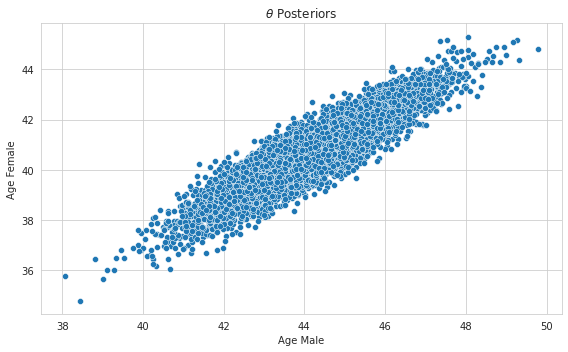

In [107]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.scatterplot(data=pd.DataFrame(list(map(lambda x: x[0], samples))), x=0, y=1, ax=ax)
ax.set_xlabel("Age Male")
ax.set_ylabel("Age Female")
ax.set_title("$\\theta$ Posteriors")

fig.tight_layout()
fig.show()

<AxesSubplot:xlabel='0', ylabel='Density'>

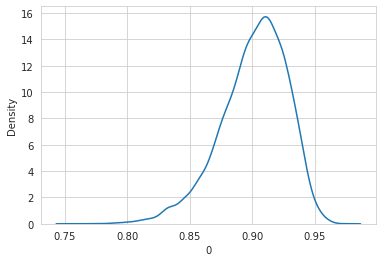

In [104]:
sns.kdeplot(data=pd.DataFrame(list(map(lambda x: x[2], samples))), x=0)

In [105]:
pd.DataFrame(list(map(lambda x: x[0], samples))).corr().iloc[0,1]

0.90397551271788

In [106]:
pd.DataFrame(list(map(lambda x: x[0], samples))).quantile([0.25, 0.975])

,0,1
0.250,43.349122,39.877588
0.975,46.827722,43.212261
